In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import isodate
import urltools
import urllib
from scipy.stats import mannwhitneyu
import re
import os.path
from langdetect import detect
import string
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import fastcluster
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from scipy.spatial.distance import squareform
import sys
from scipy.cluster.hierarchy import fcluster, dendrogram
from nltk.stem.porter import PorterStemmer
from ggplot import *
import utils
from statsmodels.distributions.empirical_distribution import ECDF
import warnings
warnings.filterwarnings('ignore')
sys.setrecursionlimit(100000)
matplotlib.style.use('ggplot')

## Pinterest - Exploratory Analyses
### Loading the dataset
First, let us load the dataset from the database.

In [3]:
con = sqlite3.connect('../../crawler/Pinterest/pinterest.db')
pin = pd.read_sql_query('SELECT * from pin', con)
url = pd.read_sql_query('SELECT * from url', con)
board = pd.read_sql_query('SELECT * from board', con)
urlResolve = pd.read_sql_query('SELECT * from urlResolve', con)
category = pd.read_sql_query('SELECT * from category', con)

Next, let's examine the count of pins we collected. The tables are ``pins``, ``board``, ``url``, ``urlResolve``, and ``category``.

In [4]:
pin.shape

(2140462, 31)

In [5]:
list(pin.columns.values)

['autoId',
 'id',
 'link',
 'trackedLink',
 'title',
 'description',
 'descriptionHTML',
 'closeupDescription',
 'closeupUserNote',
 'type',
 'ownerId',
 'promoterId',
 'boardId',
 'originOwnerId',
 'likeCount',
 'commentCount',
 'repinCount',
 'isPromoted',
 'method',
 'isRepin',
 'priceValue',
 'priceCurrency',
 'richMetadataSiteName',
 'richMetadataDescription',
 'richMetadataTitle',
 'richMetadataLocale',
 'richMetadataUrl',
 'richMetadataType',
 'richMetadataId',
 'createdAt',
 'category']

In [6]:
url.shape

(2045678, 4)

In [7]:
list(url.columns.values)

['autoId', 'pinId', 'url', 'origin']

In [8]:
urlResolve.shape

(3286116, 5)

In [9]:
list(urlResolve.columns.values)

['autoId', 'urlId', 'url', 'urlOrder', 'code']

In [10]:
category.shape

(37, 5)

In [11]:
list(category.columns.values)

['autoId', 'id', 'name', 'type', 'key']

In [12]:
board.shape

(2145693, 10)

In [13]:
list(board.columns.values)

['autoId',
 'id',
 'name',
 'url',
 'type',
 'privacy',
 'ownerId',
 'description',
 'category',
 'boardOwnerId']

### Remove duplicated pins and boards

How many of the pins are unique?

In [14]:
pin['id'].duplicated().value_counts()

False    2140462
Name: id, dtype: int64

How many of the boards are unique?

In [15]:
board['id'].duplicated().value_counts()

True     1381615
False     764078
Name: id, dtype: int64

Remove the duplicate boards.

In [16]:
board.drop_duplicates('id', inplace=True)

In [17]:
board['id'].duplicated().value_counts()

False    764078
Name: id, dtype: int64

Set the board id as the index.

In [18]:
board.set_index('id', inplace = True)

### Examining the pins
The category of a pin is defined by its board. Let's add the categories to the pins from the boards table.

In [19]:
pin['category_board'] = pin.apply(lambda x: board.category.get(key = x.boardId, default = 'Error'), axis = 1)
pin['category_board'].fillna('default', inplace=True)

Let's examine the categories.

In [20]:
pin['category_board'].value_counts()

default                  1225278
other                     235672
food_drink                146865
diy_crafts                 63880
hair_beauty                58347
home_decor                 51970
womens_fashion             51080
art                        25861
humor                      24762
weddings                   22116
holidays_events            19846
quotes                     19632
health_fitness             18783
animals                    18363
design                     17530
education                  15722
travel                     13678
gardening                  13566
kids                       13319
photography                12627
film_music_books           12573
products                    8670
tattoos                     7534
celebrities                 6795
architecture                5755
geek                        5058
outdoors                    4882
cars_motorcycles            4263
illustrations_posters       3847
science_nature              3186
history   

How many pins do we have in each category?

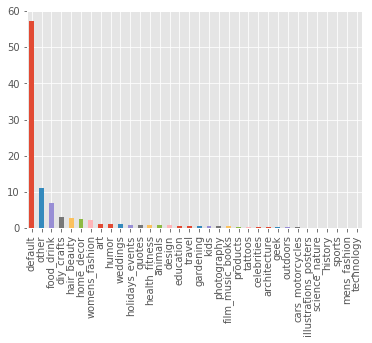

In [21]:
((pin['category_board'].value_counts() * 100.0) / len(pin['category_board'])).plot.bar()
plt.show()

#### Pin creation times
When were these pins published?

In [22]:
pin['createdAtYear'] = pin.apply(lambda x: x.createdAt.split(' ')[3], axis = 1)

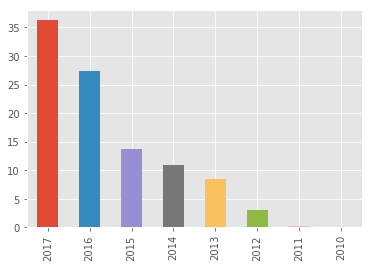

In [23]:
((pin['createdAtYear'].value_counts() * 100.0) / len(pin['createdAt'])).plot.bar()
plt.show()

In [24]:
pin['createdAtMonth'] = pin.apply(lambda x: x.createdAt.split(' ')[2], axis = 1)

In [25]:
pin['createdAtMonth'].value_counts()

Sep    248285
Aug    232178
Oct    216435
Jul    206024
Jan    183928
Mar    172393
Jun    167004
Feb    166340
May    161522
Nov    140304
Dec    133655
Apr    112394
Name: createdAtMonth, dtype: int64

#### Pin re-pins
How do the re-pin counts vary?

In [26]:
pin['repinCount'] = pd.to_numeric(pin['repinCount'])
pin['repinCount'].describe()

count    2.140462e+06
mean     1.062455e+00
std      8.383927e+01
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.653300e+04
Name: repinCount, dtype: float64

In [27]:
pin['repinCount'] = pin['repinCount'].abs()

In [28]:
pin['repinCount'].describe()

count    2.140462e+06
mean     1.062482e+00
std      8.383927e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.653300e+04
Name: repinCount, dtype: float64

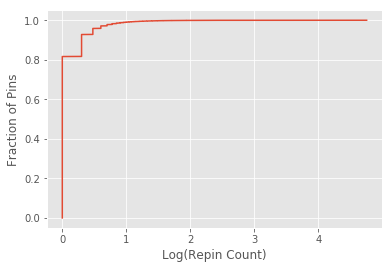

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Log(Repin Count)')
ax.set_ylabel('Fraction of Pins')
cdf = ECDF(pin['repinCount'])
x_values = [np.log10(x + 1) for x in cdf.x[1:]]
plt.plot(x_values, cdf.y[1:])
plt.show()

#### Pin likes
How many likes do the pins have?

In [30]:
pin['likeCount'] = pd.to_numeric(pin['likeCount'])
pin['likeCount'].describe()

count    2140462.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: likeCount, dtype: float64

#### Pin comments
How many comments do the pins have?

In [31]:
pin['commentCount'] = pd.to_numeric(pin['commentCount'])
pin['commentCount'].describe()

count    2.140462e+06
mean     2.717638e-03
std      1.826925e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.560000e+02
Name: commentCount, dtype: float64

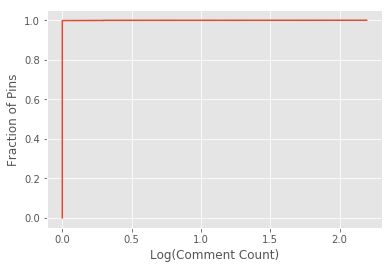

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Log(Comment Count)')
ax.set_ylabel('Fraction of Pins')
cdf = ECDF(pin['commentCount'])
x_values = [np.log10(x + 1) for x in cdf.x[1:]]
plt.plot(x_values, cdf.y[1:])
plt.show()

#### Pin repin characteristics
How many of these pins were repins?

In [33]:
pin['isRepin'].value_counts()

1    1970086
0     170376
Name: isRepin, dtype: int64

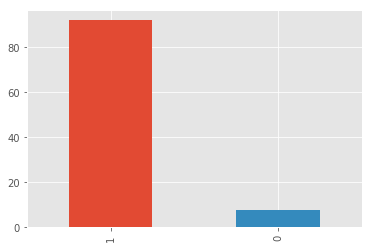

In [34]:
((pin['isRepin'].value_counts() * 100.0) / len(pin['isRepin'])).plot.bar()
plt.show()

How many of these pins were promoted?

In [35]:
pin['isPromoted'].value_counts()

0    2140462
Name: isPromoted, dtype: int64

How many of the Pin URLs were duplicated?

In [36]:
pin['link'].duplicated().value_counts()

False    1413508
True      726954
Name: link, dtype: int64

### Manipulating the URLs

Add functions that dissect the URL to reveal the various parts.

In [37]:
def get_domain(x):
    return urltools.parse(x.url).domain.lower()

def get_path(x):
    return urllib.unquote(urltools.parse(x.url).path).lower()

def get_subdomain(x):
    sd = urltools.parse(x.url).subdomain.lower()
    if sd.startswith('www.'):
        return sd[4:]
    return sd

def get_params(x):
    return urllib.unquote(urltools.parse(x.url).query).lower()

In [38]:
list(urlResolve.columns.values)

['autoId', 'urlId', 'url', 'urlOrder', 'code']

In [39]:
urlResolve['urlDomain'] = urlResolve.apply(get_domain, axis=1)
urlResolve['urlPath'] = urlResolve.apply(get_path, axis=1)
urlResolve['urlSubDomain'] = urlResolve.apply(get_subdomain, axis=1)
urlResolve['urlParams'] = urlResolve.apply(get_params, axis=1)

Mark all the following patterns as affiliate links.

In [40]:
def check_affiliate_link(x):
    params_list = map(lambda y: y.split('=')[0], x.urlParams.split('&'))
    regexp_clickbank = re.compile(r'.*.hop')
    regexp_anrdoezrs = re.compile(r'/click-[0-9]+-[0-9]+')
    regexp_buyeasy_1 = re.compile(r'/cashback.*')
    regexp_buyeasy_2 = re.compile(r'/redirect.*')
    regexp_admitad_1 = re.compile(r'/g/.*')
    regexp_admitad_2 = re.compile(r'/goto/.*')
    regexp_impactradius = re.compile(r'/c/[0-9]+/[0-9]+/[0-9]+')
    regexp_pepperjam = re.compile(r'/t/[0-9]-[0-9]+-[0-9]+-[0-9]+')
    
    if ((x.urlDomain == 'affiliaxe' and 'aff_id' in params_list) or
        (x.urlDomain == 'aliexpress' and 'af' in params_list) or
        (x.urlDomain == 'amazon' and 'tag' in params_list) or
        (x.urlDomain == 'apessay' and 'rid' in params_list) or
        (x.urlDomain == 'apple' and 'at' in params_list) or
        (x.urlDomain == 'audiojungle' and 'ref' in params_list) or
        (x.urlDomain == 'awin1' and 'awinaffid' in params_list) or
        (x.urlDomain == 'zanox' and x.urlPath == '/ppc') or
        (x.urlDomain == 'zenaps' and x.urlPath == '/rclick.php') or
        (x.urlDomain == 'banggood' and 'p' in params_list) or
        (x.urlDomain == 'bookdepository' and 'a_aid' in params_list) or
        (x.urlDomain == 'booking' and 'aid' in params_list) or
        (x.urlDomain == 'ebay' and 'campid' in params_list) or
        (x.urlDomain == 'envato' and 'ref' in params_list) or
        (x.urlDomain == 'gtomegaracing' and 'tracking' in params_list) or
        (x.urlDomain == 'hotellook' and 'marker' in params_list) or
        (x.urlDomain == 'hotmart' and 'a' in params_list) or
        (x.urlDomain == 'kontrolfreek' and 'a_aid' in params_list) or
        (x.urlDomain == 'shareasale' and x.urlPath == '/r.cfm') or
        (x.urlDomain == 'shareasale' and x.urlPath == '/m-pr.cfm') or
        (x.urlDomain == 'shareasale' and x.urlPath == '/u.cfm') or
        (x.urlDomain == 'rstyle') or
        (x.urlDomain == 'shopstyle') or
        (x.urlDomain == 'makeupgeek' and 'acc' in params_list) or
        (x.urlDomain == 'olymptrade' and 'affiliate_id' in params_list) or
        (x.urlDomain == 'videohive' and 'ref' in params_list) or
        (x.urlDomain == 'avantlink' and 'pw' in params_list) or
        (x.urlDomain == 'avangate' and 'AFFILIATE'.lower() in params_list) or
        (x.urlDomain == 'redirectingat' and 'id' in params_list) or
        (x.urlDomain == 'linksynergy' and x.urlSubDomain == 'click' and 'id' in params_list) or
        (x.urlDomain == 'audiobooks' and 'a_aid' in params_list and 'a_bid' in params_list) or
        (x.urlDomain == 'buyeasy' and regexp_buyeasy_1.search(x.urlPath)) or
        (x.urlDomain == 'buyeasy' and regexp_buyeasy_2.search(x.urlPath)) or
        (x.urlDomain == 'clickbank' and regexp_clickbank.search(x.urlSubDomain)) or
        
        ((x.urlDomain == '7eer' or x.urlDomain == 'evyy' or x.urlDomain == 'ojrq' ) and regexp_impactradius.search(x.urlPath)) or
        
        ((x.urlDomain == 'anrdoezrs' or x.urlDomain == 'dpbolvw' or x.urlDomain == 'kqzyfj' or x.urlDomain == 'jdoqocy' or x.urlDomain == 'tkqlhce') and regexp_anrdoezrs.search(x.urlPath)) or
        (x.urlDomain == 'emjcd') or
        (x.urlDomain == 'dotomi') or
        (x.urlDomain == 'qksrv') or
        
        (x.urlDomain == 'zaful' and 'lkid' in params_list) or
        (x.urlDomain == 'codecanyon' and 'ref' in params_list) or
        (x.urlDomain == 'graphicriver' and 'ref' in params_list) or
        (x.urlDomain == 'themeforest' and 'ref' in params_list) or
        (x.urlDomain == 'admitad' and (regexp_admitad_1.search(x.urlPath) or regexp_admitad_2.search(x.urlPath))) or
        (x.urlDomain == 'flipkart' and 'affid' in params_list) or
        
        ((x.urlDomain == 'pntra' or
        x.urlDomain == 'gopjn' or
        x.urlDomain == 'pjtra' or
        x.urlDomain == 'pjatr' or
        x.urlDomain == 'pntrs' or
        x.urlDomain == 'pntrac') and (regexp_pepperjam.search(x.urlPath)))
       ):
        
            return True
        
    return False

urlResolve['affiliateLink'] = urlResolve.apply(check_affiliate_link, axis=1)

How many of these resolved links were affiliate in nature?

In [41]:
urlResolve['affiliateLink'].value_counts()

False    3254951
True       31165
Name: affiliateLink, dtype: int64

How did these resolved affiliate links vary by domain?

In [42]:
(urlResolve[urlResolve['affiliateLink'] == True]).groupby(['urlDomain'])['autoId'].count().sort_values(ascending=False)

urlDomain
shopstyle        9239
amazon           7368
rstyle           2711
ebay             1963
linksynergy      1877
graphicriver     1465
zaful             786
aliexpress        785
dotomi            783
emjcd             775
shareasale        616
evyy              399
anrdoezrs         365
clickbank         262
envato            262
themeforest       200
kqzyfj            158
redirectingat     155
awin1             151
7eer              130
jdoqocy           110
qksrv             104
dpbolvw            88
codecanyon         76
apple              61
zenaps             60
videohive          33
tkqlhce            30
gopjn              25
flipkart           20
pntrac             16
pjtra              16
banggood           13
avantlink          12
hotmart             8
pjatr               8
buyeasy             7
booking             7
pntrs               7
pntra               7
hotellook           5
ojrq                1
admitad             1
Name: autoId, dtype: int64

Retain only those original URLs that were affiliate in nature.

In [43]:
affiliate_urls = url[url['autoId'].isin(urlResolve[urlResolve['affiliateLink'] == True].urlId.tolist())]

How many URLs were retained?

In [44]:
affiliate_urls.shape

(21025, 4)

How many pins do these URLs correspond to?

In [45]:
affiliate_pins = pin[pin['id'].isin(affiliate_urls['pinId'].tolist())].copy()
affiliate_pins.shape

(18584, 34)

What were the sources of the URLs in these pins?

In [46]:
affiliate_urls['origin'].value_counts()

link                  18237
closeupUserNote        1381
description            1379
closeupDescription       28
Name: origin, dtype: int64

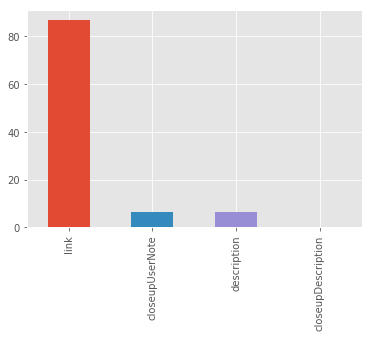

In [47]:
((affiliate_urls['origin'].value_counts() * 100.0) / len(affiliate_urls['origin'])).plot.bar()
plt.show()

In [48]:
affiliate_urls = affiliate_urls[affiliate_urls['origin'] == 'link']

#### Affiliate pin catgories
How did these affiliate pins vary by category?

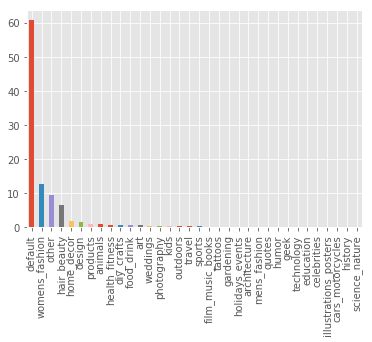

In [49]:
((affiliate_pins['category_board'].value_counts() * 100.0) / len(affiliate_pins['category_board'])).plot.bar()
plt.show()

#### Affiliate pins % by category
How did these affiliate pins vary as a function of the overall number of pins in each category?

In [50]:
((affiliate_pins['category_board'].value_counts()*100.0)/pin['category_board'].value_counts()).sort_values(ascending=False)

womens_fashion           4.622161
products                 2.214533
hair_beauty              2.041236
sports                   1.626355
design                   1.534512
outdoors                 1.208521
technology               1.162791
mens_fashion             1.129707
animals                  0.996569
default                  0.920852
other                    0.737466
health_fitness           0.633552
home_decor               0.611891
photography              0.538529
kids                     0.473008
architecture             0.469157
tattoos                  0.424741
art                      0.375082
weddings                 0.325556
travel                   0.321684
geek                     0.276789
film_music_books         0.262467
gardening                0.206398
diy_crafts               0.173763
holidays_events          0.141086
quotes                   0.132437
illustrations_posters    0.129971
celebrities              0.103017
history                  0.096899
science_nature

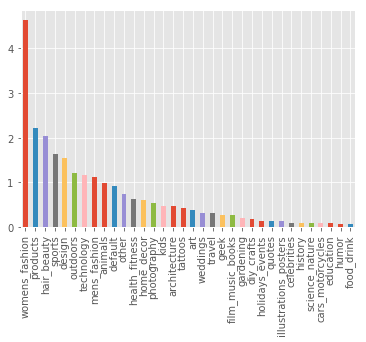

In [51]:
(((affiliate_pins['category_board'].value_counts()*100.0)/pin['category_board'].value_counts()).sort_values(ascending=False)).plot.bar()
plt.show()

In [52]:
(pin['category'] == pin['category_board']).value_counts()

False    1615590
True      524872
dtype: int64

#### Affiliate pins repins
How many of the affiliate pins are repins?

In [53]:
affiliate_pins['isRepin'].value_counts()

1    15250
0     3334
Name: isRepin, dtype: int64

Is this different from the non-affiliate pins?

In [54]:
non_affiliate_pins = pin[~pin['id'].isin(affiliate_urls['pinId'].tolist())]
non_affiliate_pins['isRepin'].value_counts()

1    1955139
0     167086
Name: isRepin, dtype: int64

#### Affiliate pins repin counts
How do the repin counts of the affiliate pins vary?

In [57]:
dat_affiliate = utils.cdf(np.log10(affiliate_pins['repinCount'] + 1), 'repinCount')
dat_affiliate['Type'] = 'Affiliate pins'
dat_non_affiliate = utils.cdf(np.log10(non_affiliate_pins['repinCount'] + 1), 'repinCount')
dat_non_affiliate['Type'] = 'Non-affiliate pins'
dat_all = utils.cdf(np.log10(pin['repinCount'] + 1), 'repinCount')
dat_all['Type'] = 'All'
dat = pd.concat([dat_affiliate, dat_non_affiliate, dat_all])

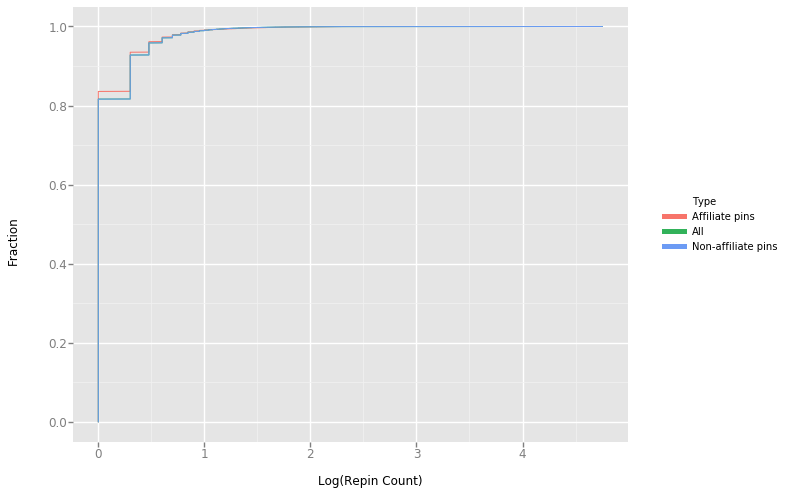

<ggplot: (723159813)>

In [58]:
ggplot(dat, aes(x = 'repinCount', y='Fraction', color='Type')) + geom_path() + xlab('Log(Repin Count)')

In [59]:
mannwhitneyu(affiliate_pins['repinCount'].tolist(), non_affiliate_pins['repinCount'].tolist())

MannwhitneyuResult(statistic=19339415996.0, pvalue=8.746349220564776e-12)

### Examining the affiliate pin descriptions

What languages are these descriptions in?

In [60]:
def get_language(x):
    language = 'Unknown'
    try:
        language = detect(x.description.strip())
    except:
        pass
    return language

affiliate_pins['description_language'] = affiliate_pins.apply(get_language, axis=1)

In [61]:
affiliate_pins['description_language'].value_counts()

en         11443
Unknown     2503
de           711
fr           412
no           379
so           288
ro           286
nl           220
it           215
es           212
ca           205
af           194
da           167
cy           152
pt           146
et           124
tl           116
fi           109
sv           103
id           100
pl            64
sl            61
sq            55
vi            49
tr            44
sw            41
lt            30
cs            28
sk            24
hr            23
hu            19
uk            16
el            14
lv            13
ru             5
mk             4
bg             3
ja             2
ko             2
he             1
zh-cn          1
Name: description_language, dtype: int64

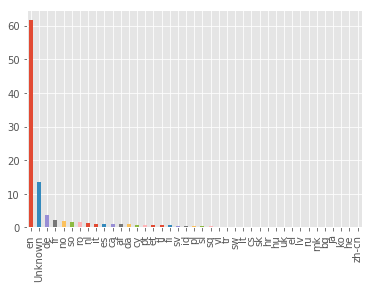

In [62]:
((affiliate_pins['description_language'].value_counts() * 100) / sum(affiliate_pins['description_language'].value_counts())).plot.bar()
plt.show()

How many lines do these descriptions contain?

In [63]:
affiliate_pins['description_line_count'] = affiliate_pins.apply(lambda x: len(x.description.splitlines()), axis=1)
affiliate_pins['description_line_count'].describe()

count    18584.000000
mean         0.999623
std          0.019405
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: description_line_count, dtype: float64

How many characters do these descriptions contain?

In [64]:
affiliate_pins['description_character_count'] = affiliate_pins.apply(lambda x: len(x.description) - x.description.count('\n') - x.description.count(' '), axis=1)
affiliate_pins['description_character_count'].describe()

count    18584.000000
mean        55.209535
std         63.211329
min          0.000000
25%         14.000000
50%         35.000000
75%         73.000000
max       1005.000000
Name: description_character_count, dtype: float64

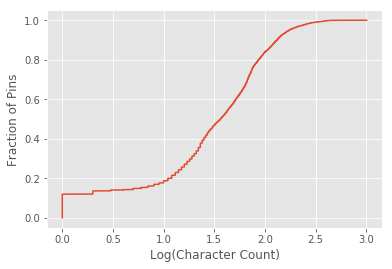

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Log(Character Count)')
ax.set_ylabel('Fraction of Pins')
cdf = ECDF(affiliate_pins['description_character_count'])
x_values = [np.log10(x + 1) for x in cdf.x[1:]]
plt.plot(x_values, cdf.y[1:])
plt.show()

Moving forward, let's only examine the videos that contain descriptions in English.

In [66]:
affiliate_pins_en = affiliate_pins[affiliate_pins['description_language'] == 'en'].copy()

Next, let's cluster these by the sentences they contain. First, let's write routines to tokenize the sentences.

In [98]:
stemmer = PorterStemmer()

def tokenize(line):
    if (line is None):
        line = ''
    printable = set(string.printable)
    line = ''.join(filter(lambda x: x in printable, line)) 
    stopwords = nltk.corpus.stopwords.words('english')

    tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]*\'[a-zA-Z]*|\w+')
    
    tokens = []
    
    line = re.sub(r'(http[s]?://|www.)(?:[a-zA-Z]|[0-9]|[$-_@.&+]*|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))*', '', line).lower()
    tokens.extend(tokenizer.tokenize(line))
    
    tokens_ = [f.strip(string.punctuation) for f in tokens]
    tokens_ = [f for f in tokens_ if f != '' and f not in stopwords and len(f) != 1]
    tokens_ = [f for f in tokens_ if not (f.isdigit() or f[0] == '-' and f[1:].isdigit())]
    tokens_ = [stemmer.stem(f) for f in tokens_]

    return tokens_

Next, let's divide the documents into lines, and expand the dataframe.

In [99]:
rows = []

def description_parse(desc):
    sentences = []
    for line in desc.splitlines():
        for sent in sent_tokenize(line):
            sentences.append(sent)
    
    return sentences

affiliate_pins_en.reset_index().apply(lambda row: [rows.append([row['id'], row['description'], sent])
                                       for sent in description_parse(row.description) if (len(tokenize(sent)) != 0)], axis = 1)
affiliate_pins_en_new = pd.DataFrame(rows, columns=['id', 'description', 'sentence'])

How many sentences do we have?

In [100]:
len(affiliate_pins_en_new.index)

16173

How many words do we have in each sentence?

In [101]:
affiliate_pins_en_new['sentence_word_count'] = affiliate_pins_en_new.apply(lambda x: len(x.sentence.split(' ')), axis=1)
affiliate_pins_en_new['sentence_word_count'].describe()

count    16173.000000
mean        10.314104
std         10.103926
min          1.000000
25%          4.000000
50%          8.000000
75%         14.000000
max        187.000000
Name: sentence_word_count, dtype: float64

In [102]:
countVec = CountVectorizer(tokenizer=tokenize, binary=True).fit(affiliate_pins_en_new['sentence'])

What is the size of the vocabulary?

In [103]:
len(countVec.vocabulary_)

13904

Let's create the bag of words representation.

In [104]:
lineVec = countVec.transform(affiliate_pins_en_new['sentence'])

#### Ward and Euclidean

First, let's compute the euclidean distance matrix from the above.

In [105]:
dist = euclidean_distances(lineVec)

Next, let's convert this to vector format. This is necessary as the linkage method below requires it in this format.

In [106]:
distVec = squareform(dist, checks = False)

Finally, let's cluster the lines.

In [107]:
res = fastcluster.linkage(distVec, method = 'ward', preserve_input = False)

Let's visualize the clusters.

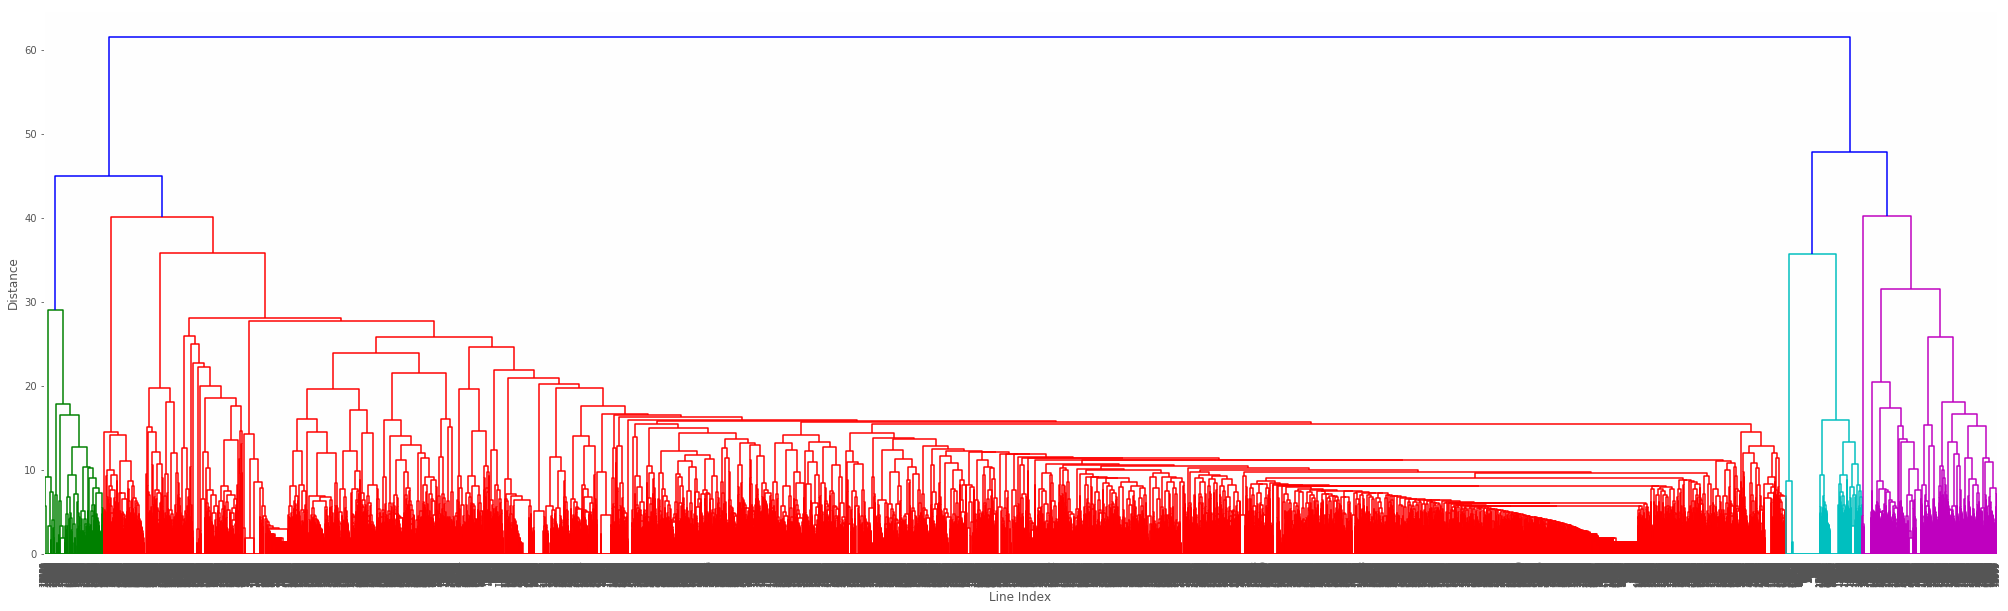

In [108]:
plt.figure(figsize=(35, 10))
plt.xlabel('Line Index')
plt.ylabel('Distance')
dendrogram(
    res,
    leaf_rotation=90.,  
    leaf_font_size=8.,  
)
plt.show()

Let's write the cluster numbers to a column in the data, and output the file.

In [109]:
affiliate_pins_en_new['ward_euclidean_cluster'] = fcluster(res, 5, criterion='distance')

In [110]:
#affiliate_pins_en_new.to_csv('clusters.csv', encoding='utf-8', columns=['id', 'sentence', 'ward_euclidean_cluster'], index=False)

In [114]:
a = [99, 100, 101, 103, 104, 106, 137, 138, 139, 226, 764, 833, 836, 1668] + range(1495, 1558)
affiliate_pins_en_new['affiliate_link_disclosure'] = False
affiliate_pins_en_new.loc[affiliate_pins_en_new['ward_euclidean_cluster'].isin(a), 'affiliate_link_disclosure'] = True
                                                                               
affiliate_pins_en_new['affiliate_link_expl_disclosure'] = False
affiliate_pins_en_new.loc[affiliate_pins_en_new['ward_euclidean_cluster'].isin([1493, 1494]), 'affiliate_link_expl_disclosure'] = True


In [115]:
affiliate_pins_en['affiliate_link_disclosure'] = affiliate_pins_en.apply(lambda x: True if x.id in affiliate_pins_en_new[affiliate_pins_en_new['affiliate_link_disclosure'] == True]['id'].unique() else False, axis = 1)
affiliate_pins_en['affiliate_link_expl_disclosure'] = affiliate_pins_en.apply(lambda x: True if x.id in affiliate_pins_en_new[affiliate_pins_en_new['affiliate_link_expl_disclosure'] == True]['id'].unique() else False, axis = 1)

In [116]:
affiliate_pins_en['affiliate_link_disclosure'].value_counts()

False    10940
True       528
Name: affiliate_link_disclosure, dtype: int64

In [117]:
affiliate_pins_en['affiliate_link_expl_disclosure'].value_counts()

False    11189
True       279
Name: affiliate_link_expl_disclosure, dtype: int64

In [118]:
affiliate_pins_en['disclosure_present'] = affiliate_pins_en.apply(lambda x: True if x.affiliate_link_disclosure == True or x.affiliate_link_expl_disclosure == True else False, axis = 1)
affiliate_pins_en['disclosure_present'].value_counts()

False    10662
True       806
Name: disclosure_present, dtype: int64

In [126]:
len(affiliate_pins_en[affiliate_pins_en['affiliate_link_disclosure'] == True]['ownerId'].unique())

186

In [127]:
len(affiliate_pins_en[affiliate_pins_en['affiliate_link_expl_disclosure'] == True]['ownerId'].unique())

24

In [128]:
len(affiliate_pins_en[affiliate_pins_en['disclosure_present'] == True]['ownerId'].unique())

207

In [136]:
len(affiliate_pins_en['ownerId'].unique())

6330

In [141]:
dat = pd.DataFrame({'Count': affiliate_pins_en[affiliate_pins_en['disclosure_present'] == True]['category'].value_counts(),
             'Total': affiliate_pins_en['category'].value_counts(),
                        'Influencer_Disclosing': affiliate_pins_en[affiliate_pins_en['disclosure_present'] == True][['category','originOwnerId']].groupby('category').originOwnerId.nunique(),
'Total_Influncers': affiliate_pins_en[['category','originOwnerId']].groupby('category').originOwnerId.nunique()})

dat['perc'] = (dat['Count'] * 100) / dat['Total']


In [142]:
dat.sort_values('Total', ascending = False)

,Count,Influencer_Disclosing,Total,Total_Influncers,perc
womens_fashion,215.0,39.0,5107,960,4.209908
,5.0,1.0,1279,9,0.390930
hair_beauty,106.0,20.0,932,238,11.373391
home_decor,55.0,18.0,751,248,7.323569
diy_crafts,37.0,14.0,646,162,5.727554
animals,236.0,26.0,389,71,60.668380
sports,10.0,3.0,325,14,3.076923
design,1.0,1.0,319,64,0.313480
health_fitness,25.0,5.0,196,45,12.755102
photography,5.0,1.0,172,56,2.906977


In [124]:
dat_year = pd.DataFrame({'number_affiliate': affiliate_pins_en['createdAtYear'].value_counts(), 'number_disclosure': affiliate_pins_en[affiliate_pins_en['disclosure_present'] == True].groupby('createdAtYear').size()})
dat_year['perc'] = (dat_year['number_disclosure'] * 100) / dat_year['number_affiliate']
dat_year[['number_disclosure', 'number_affiliate', 'perc']]


,number_disclosure,number_affiliate,perc
2012,NaN,103,NaN
2013,NaN,384,NaN
2014,NaN,624,NaN
2015,NaN,1015,NaN
2016,50.0,2595,1.926782
2017,756.0,6747,11.204980
